# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [2]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd 
import matplotlib.pyplot as plt
import time
from scipy import signal

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [4]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [5]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [6]:
play = False
if play :
    play_sound(sound) 

In [7]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [8]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

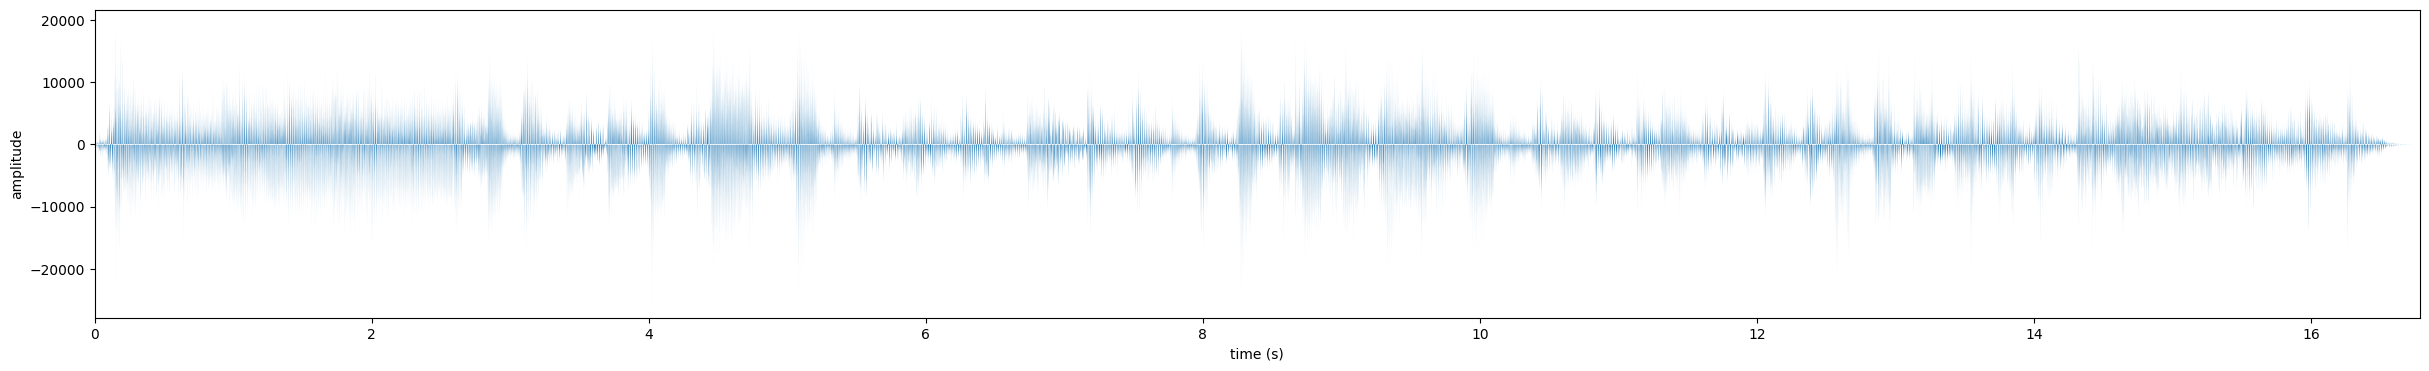

In [9]:
plot_sound(x, times)

In [10]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## **Conversion of sampling rate**
### **Question 1**  
![Texte alternatif](schéma_tsi201_tp1.png "schéma_tsi201_tp1.png")
avec L= 2 et M=3

### **Question 2**

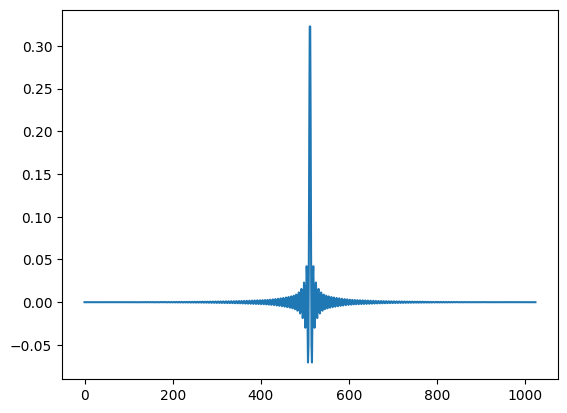

In [11]:
#Synthesizing an impulse response for the sampling rate
N=1024
nu_c= 1/6
h = signal.remez(N,[0, nu_c, nu_c+0.005, 0.5],[1,0])
plt.plot(h)


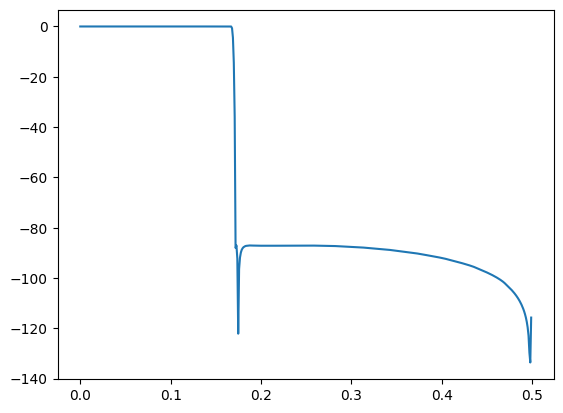

In [12]:
#Plotting the frequency response to make sure the synthesis was correct
w, H = signal.freqz(h, [1], fs=1)
plt.plot(w, 20*np.log10(np.abs(H)))
plt.show()


We have a 70dB difference between the pass band and the stop band, which is greater than the 50 dB requirement

### Question 3 : Digital processing chain

0.25594496726989746


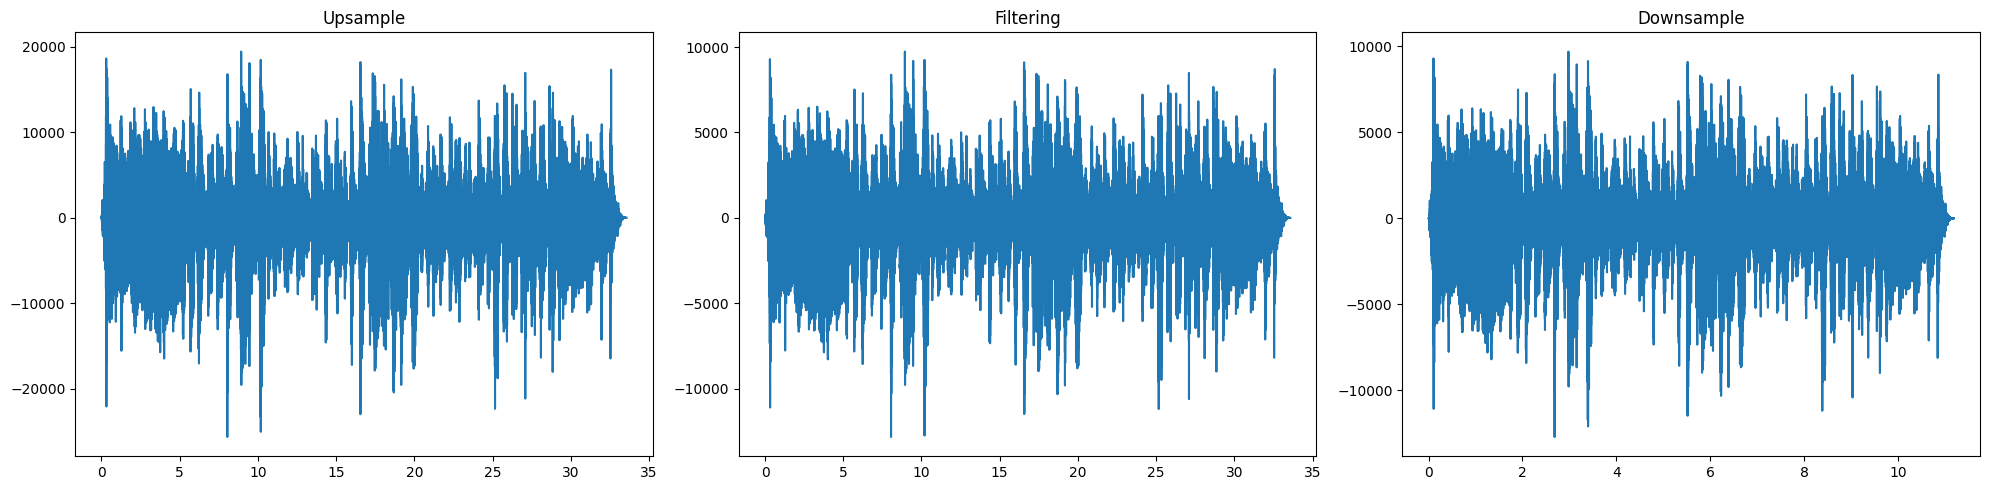

In [13]:
t = time.time()

#Simplest chain to achieve the conversions
L,M=2,3

#Upsampling
w_long=np.zeros((L*len(x))) 
w_long[::L]=x

#Filtering
w_filter=signal.lfilter(h, [1], w_long)

#Downsampling
w_short=w_filter[::M]

print(time.time()-t)

#Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].plot(np.arange(len(w_long))/Fs,w_long)
axes[0].set_title('Upsample')
axes[1].plot(np.arange(len(w_filter))/Fs,w_filter)
axes[1].set_title('Filtering')
axes[2].plot(np.arange(len(w_short))/Fs,w_short)
axes[2].set_title('Downsample')
fig.tight_layout()




### Question 4 : Equivalence between the 2 diagram below 
![Texte alternatif](diagram_tsia.png "diagram tp stft tsia201.png")

Let X, U, Z, Y be the resulting signals in the first diagram and X, U, Z, W, Y be the resulting signals in the second diagram.  

For the first diagram, we have : 

\begin{align*}
U(z) = X(z^2)\\
Z(z) = z^{-1}X(z^2)\\
Y(z) = z^{ -\frac{1}{3} } \cdot X(z^{ \frac{2}{3} })

\end{align*}

And for the second diagram :  

\begin{align*}
U(z) = zX(z)\\
Z(z) = z^{ \frac{1}{3} } X(z^{ \frac{1}{3} })\\
W(z) =z^{ \frac{2}{3} } X(z^{ \frac{2}{3} }) \\
X(z) =z^{ \frac{-1}{3} } X(z^{ \frac{2}{3} }) 
\end{align*}


### Question 4 : Programm the polyphase decomposition
![Texte alternatif](schema_polyphase.jpeg "schema_polyphase.jpeg")

In [14]:
#Definition of the polyphase descomposition 
r1 = h[::2]
r0 = h[1::2]

e00 = r0[::3]
e01 = r0[1::3]
e02 = r0[2::3]

e10 = r1[::3]
e11 = r1[1::3]
e12 = r1[2::3]


Time of execution:  0.2407064437866211


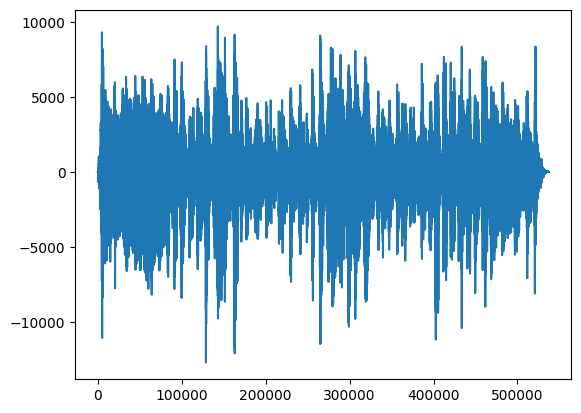

In [15]:
t = time.time()
#Time shifting

x00=x.copy()
x00 = x[1:] 
x00[-1]=0 #multiplication de x pr z

x01 = x.copy()

x02= x.copy()
x02[1:] = x[:len(x)-1] 
x02[0]=0 #multiplication de x par z^-1

#Downsampling
x00m=x00[::3]
x01m=x01[::3]
x02m=x02[::3]


#Filtering
w00 = signal.lfilter(e00,1,x00m) # w00 is the signal filtered by e00
w01 = signal.lfilter(e01,1,x01m) # w01 is the signal filtered by e01
w02 = signal.lfilter(e02,1,x02m) # w02 is the signal filtered by e02

#Sum and then upsampling
w0 = w00 + w01 + w02
w0temp = np.zeros(2*len(w0))
w0temp[::2] = w0
#shifting  by z^-1
w0f = np.zeros(len(w0temp))
w0f[1:] = w0temp[:len(w0temp)-1]
w0f[0] = 0

#########

x10 = x.copy()

x11= x.copy() #multiplication de x par z^-1
x11[1:] = x[:len(x)-1] 
x11[-1]=0

x12= x.copy()
x12[2:] = x[:len(x)-2] 
x12[:2]=0

#Downsampling
x10m=x10[::3]
x11m=x11[::3]
x12m=x12[::3]

#filtering
w10 = signal.lfilter(e10,1,x10m)  # w10 is the signal filtered by e10
w11 = signal.lfilter(e11,1,x11m)  # w11 is the signal filtered by e11
w12 = signal.lfilter(e12,1,x12m)  # w12 is the signal filtered by e12

#Sum and then upsampling
w1 = w10 + w11 + w12
w1f = np.zeros(2*len(w1))
w1f[::2] = w1

y = w0f + w1f
plt.plot(y)
print("Time of execution: ", time.time() - t)


In [16]:
write('y.wav', int(Fs * (2/3)), np.array(y, dtype=np.int16))
play_sound('y.wav')

## **STFT audio equalization**

## **2.1 STFT Analysis**

### **Question 1**  

C:\Users\eliot\AppData\Local\Temp\ipykernel_14136\2814999039.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(-1/2,1/2,Nw*4),np.log10(np.fft.fftshift(np.abs(wdft))))


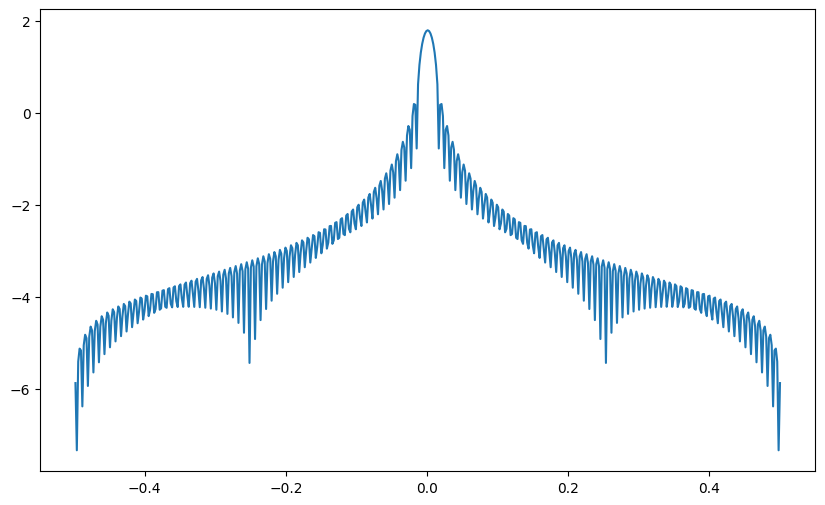

In [17]:
Nw = 128
w = np.hanning(Nw)
ws=w.copy()
wdft=np.fft.fft(w,Nw*4)
plt.figure(figsize=(10,6))
plt.plot(np.linspace(-1/2,1/2,Nw*4),np.log10(np.fft.fftshift(np.abs(wdft))))

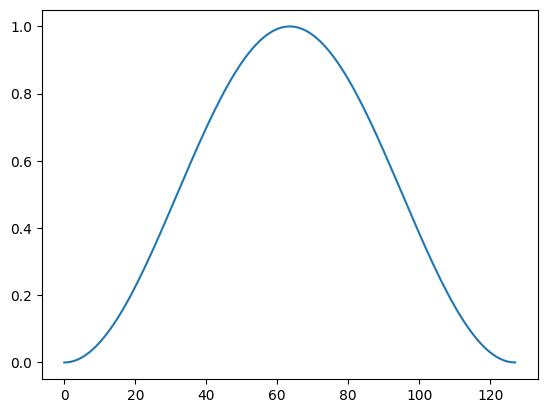

In [18]:
plt.plot(w)

The main lobe in the DFT has a 4/Nw width

### **Question 2**

La STFT correspond à une convolution entre un filtre passe bas (la fenêtre de Hann) et le signal (l'exponentielle se chargeant de décaler le signal initial). 

Le filtre FIR de hanning est de type II : Nw est pair et la filtre est symétrique. 




### **Question 3**
La STFT correspond désormais à une convolution entre le signal et la fenêtre de Hann décalé temporellement : il s'agit donc cette fois-ci du signal convolué à un filtre passe bande. 



\begin{align*}
\~{X}(\lambda, b) &= \sum_{n\in\mathbb{Z}}x(n+b)w(n)e^{-2j\pi \lambda n}\\ 
&= \sum_{n\in\mathbb{Z}}x(n)w(n-b)e^{-2j\pi \lambda (n-b)} \\
&= e^{2j\pi \lambda b}\sum_{n\in\mathbb{Z}}x(n)w(n-b) \\
&= e^{2j\pi \lambda b}W_x(\lambda, b)
\end{align*}

Le notebook implémente la convention passe bande. On récupère les fenêtres issues du signal x et on les multiplie par la fenêtre de Hann : c'est comme si on décalait la fenêtre de Hann temporellement

### **Question 4**

C:\Users\eliot\AppData\Local\Temp\ipykernel_14136\105513784.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(Xtilde[:len(Xtilde)//2])), aspect='auto',interpolation='none',


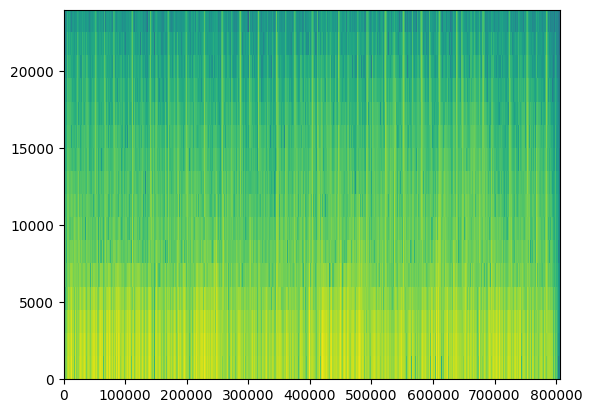

In [19]:
N=x.shape[0]
M=32 #ordre de la STFT
R=1  #Nw-overlap
k=2
L=2*M+1
Nw = M//2 #largeur de la fenêtre

w = np.hanning(Nw)
wdft=np.fft.fft(w,Nw*4)

Nt=int(np.floor((N-Nw)/R))#nombre de fenêtres
Xtilde = np.zeros((M,Nt), dtype=np.complex128)

for u in range(Nt): # boucle sur les trames
    deb = u * R # début de trame
    tx = x[deb:deb+Nw]*w # calcul de la trame multiplié par la fenêtre de Hann 
    Xtilde[:,u] =  np.fft.fft(tx,M)

plt.imshow(20*np.log10(np.abs(Xtilde[:len(Xtilde)//2])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt *R+Nw/2 / Fs, 0, Fs/2])

In [20]:
Xtilde[:,k]


array([-5.45866197+0.j        , -0.10036957+4.65035926j,
        2.7050055 +0.46472553j,  1.18702953-0.66065699j,
        0.69609559-2.08493682j, -2.75934012-1.29054343j,
       -1.52906026+2.85915325j,  2.39346225+1.74484213j,
        1.92218746-1.8017867j , -1.6462243 -1.88061567j,
       -1.57633568+2.146512j  ,  2.97600092+1.1414282j ,
        0.68587042-3.52033468j, -3.3580854 -0.18308044j,
        0.40039044+2.5160163j ,  1.3075267 -0.92949361j,
       -1.14964497+0.j        ,  1.3075267 +0.92949361j,
        0.40039044-2.5160163j , -3.3580854 +0.18308044j,
        0.68587042+3.52033468j,  2.97600092-1.1414282j ,
       -1.57633568-2.146512j  , -1.6462243 +1.88061567j,
        1.92218746+1.8017867j ,  2.39346225-1.74484213j,
       -1.52906026-2.85915325j, -2.75934012+1.29054343j,
        0.69609559+2.08493682j,  1.18702953+0.66065699j,
        2.7050055 -0.46472553j, -0.10036957-4.65035926j])

The signal is complexe, it acts as a pass-band on the original signal. We can visualize it by plotting the spectrogram of the real part of $\~{X}(3, u)$:. We can see that it is actually a pass-band and not a low pass by using a greater k. 

C:\Users\eliot\AppData\Local\Temp\ipykernel_14136\3552387127.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,20*np.log10(Sxx))


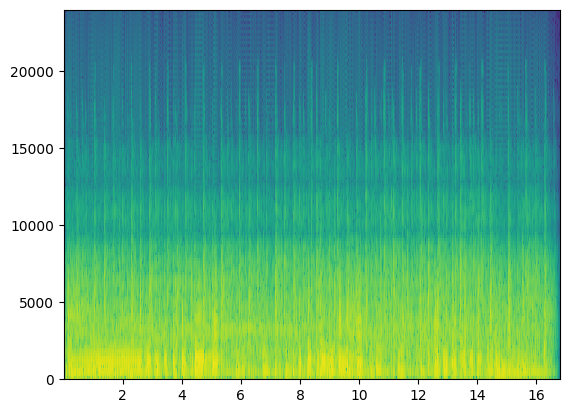

In [21]:
f,t,Sxx=signal.spectrogram(np.real(Xtilde[2]),fs=Fs,window='hann',nperseg=128,noverlap=64,nfft=256)
plt.pcolormesh(t,f,20*np.log10(Sxx))

C:\Users\eliot\AppData\Local\Temp\ipykernel_14136\2896381206.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,20*np.log10(Sxx))


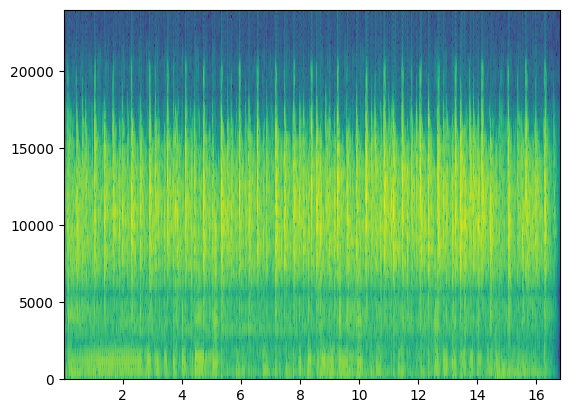

In [22]:
f,t,Sxx=signal.spectrogram(np.real(Xtilde[8]),fs=Fs,window='hann',nperseg=128,noverlap=64,nfft=256)
plt.pcolormesh(t,f,20*np.log10(Sxx))

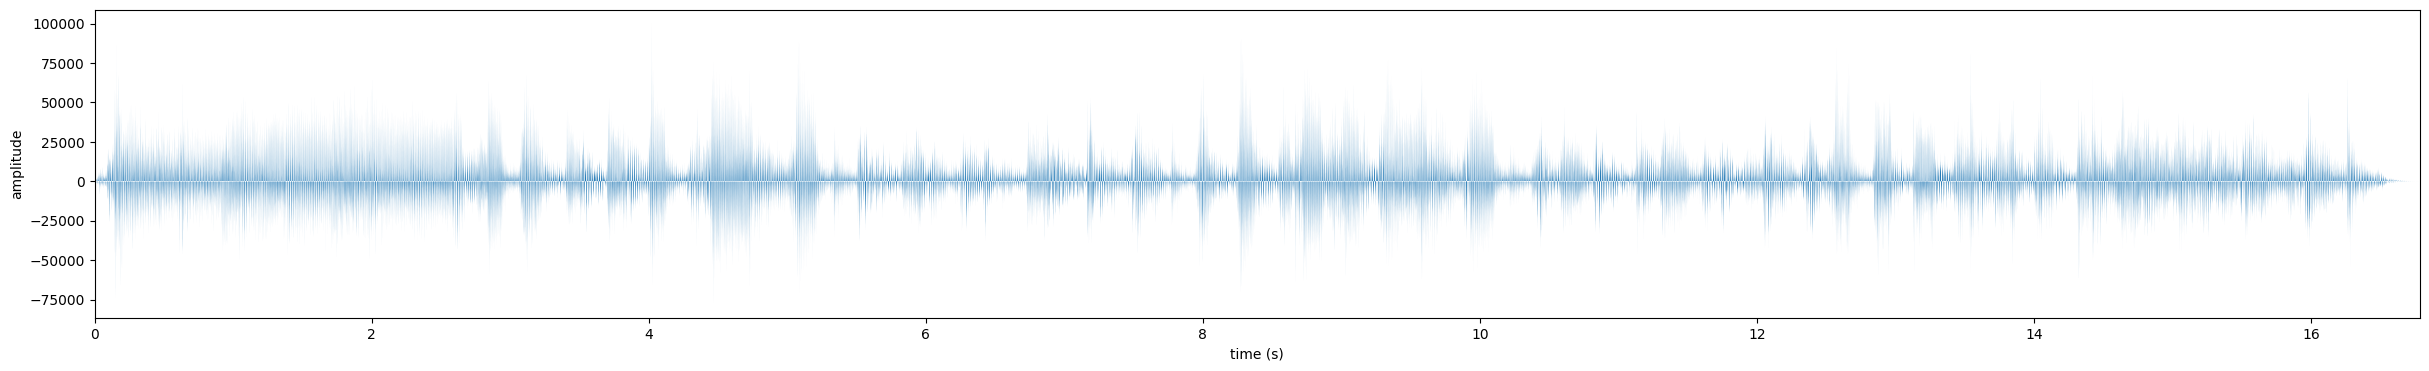

In [23]:
plot_sound(np.real(Xtilde[k]), np.arange(len(Xtilde[k]))*timestep, name='synthese', save=False)
write('synthese.wav', Fs, np.array(np.real(Xtilde[k]), dtype=np.int16))
play_sound('synthese.wav')

## **2.2 Reconstruction**
#### Overlap-add Reconstruction

In [24]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

#### Question 5

Suppose that 
\begin{align*} 
f(n) &= \sum_{u \in \mathbb{Z}} w(n- uR)ws(n-uR) \\
&= 1 \\
\end{align*} 

then 

\begin{align*}
y(n) &= \sum_{u\in\mathbb{Z}} w_{s}(n-uR)\frac{1}{M}\sum_{k=0}^{M-1}\tilde{X}(k,u)e^{\frac{j2\pi k(n-uR)}{M}}\\
&= \sum_{u\in\mathbb{Z}} w_{s}(n-uR)\sum_{m\in\mathbb{Z}}x(m+uR)w(m)\frac{1}{M}\sum_{k=0}^{M-1}e^{\frac{j2\pi k(n-m-uR)}{M}}\\
\end{align*} 

note that :

$\frac{1}{M}\sum_{k=0}^{M-1}e^{\frac{j2\pi k(n-m+uR)}{M}} = 1$ if there exist $k \in \mathbb{Z}$ such that $m=n-uR+kM\\$

However $m+uR = n + kM$ should remain smaller than the signal length N so we conclude that $k = 0$

\begin{align*}
y(n) &= \sum_{u\in\mathbb{Z}}w_{s}(n-uR)w(n-uR)x(n)\\
\end{align*}

with $f(n) = 1$, we obtain the perfect reconstruction

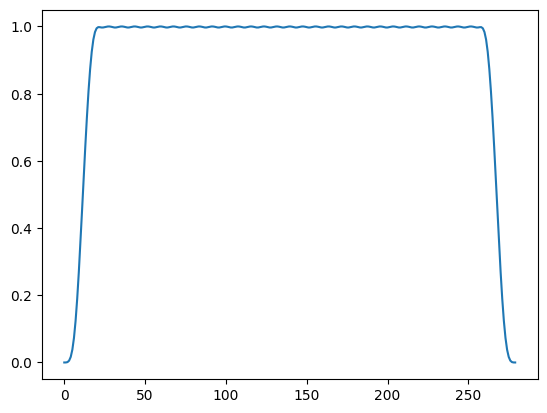

In [25]:
w=np.hanning(M)
##pourquoi M?
synthese=ola(w*w,int(0.25*M),M) #décalage de 25% pour avoir un recouvrement de 75%
synthese/=max(synthese)
plt.plot(synthese)


The condition is not strictly respected, but as the error are mostly on the edges, we'll still try to reconstruct the signal with that window

#### Question 6

In [26]:
def STFT(x,M=32,Nw=32,R=M//4):
    w = np.hanning(Nw)/np.max(np.hanning(Nw))
    Nt=int(np.floor((len(x)-Nw)/R))#nombre de fenêtres
    Xtilde = np.zeros((M,Nt), dtype=np.complex128)
    for u in range(Nt): # boucle sur les trames
        deb = u * R # début de trame
        tx = x[deb:deb+Nw]*w # calcul de la trame multiplié par la fenêtre de Hann 
        Xtilde[:,u] =  np.fft.fft(tx,M)
    return Xtilde

def reconstruction(X, M=32, Nw=32, R=M//4):
    w=np.concatenate((np.hanning(Nw),np.zeros(M-Nw)))
    y = np.zeros(Nw + R * X.shape[1])
    for u in range(X.shape[1]):
        y[u*R:u*R+Nw] += np.real(np.fft.ifft(X[:,u], M) * w)
    return y

y = reconstruction(STFT(x))
write('new_caravan2.wav', Fs, np.array(y, dtype=np.int16))
play_sound('new_caravan2.wav')

In [27]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)


In [28]:
play_sound(sound)

### **Question 7 STFT audio equalizer**

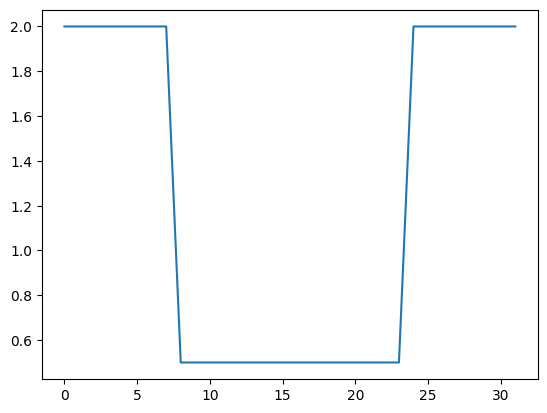

C:\Users\eliot\AppData\Local\Temp\ipykernel_14136\3511902315.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Ytilde[:,u] = np.multiply(Xtilde[:,u], wk)


In [50]:
Ytilde = np.zeros(np.shape(Xtilde))

L = M/2+1 

# Channels weights set
Ltilde= int(L)

wk = np.ones(M)
wk[:M//4]=2
wk[M//4:3*M//4]= 1/2
wk[3*M//4:]= 2


def reconstruction2(X, M=32, Nw=32, R=M//4,wk=np.ones(M)):
    w=np.concatenate((np.hanning(Nw),np.zeros(M-Nw)))
    y = np.zeros(Nw + R * X.shape[1])
    for u in range(X.shape[1]):
        Ytilde=X[:,u]*wk
        y[u*R:u*R+Nw] += np.real(np.fft.ifft(Ytilde, M) * w)
    return y

plt.plot(wk)
plt.show()
for u in range(0,Nt):
    Ytilde[:,u] = np.multiply(Xtilde[:,u], wk)



C:\Users\eliot\AppData\Local\Temp\ipykernel_14136\2387288184.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(Ytilde[np.arange(0,Ltilde, dtype=int),:])), aspect='auto',interpolation='none',


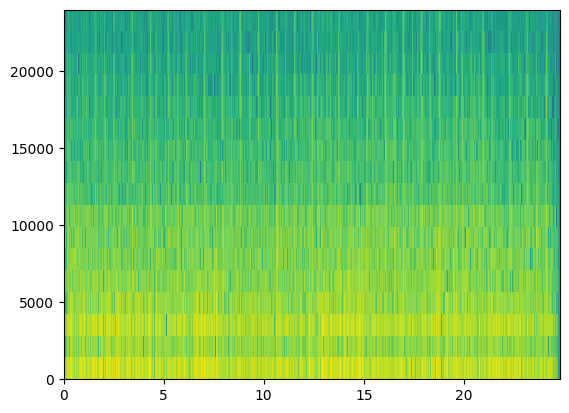

In [51]:
plt.imshow(20*np.log10(np.abs(Ytilde[np.arange(0,Ltilde, dtype=int),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
plt.show()

In [52]:
y_weight = reconstruction2(STFT(x))
write('y_weight.wav', Fs, np.array(y, dtype=np.int16))
play_sound('y_weight.wav')